In [8]:
import xarray as xr
import numpy as np
import glob

# Load temperature data
input_pattern = '/Users/epauthen/Documents/Database/Hackaton_MeteoFrance/tasmin/tasminAdjust_alpes_day_*.nc'
input_files = sorted(glob.glob(input_pattern))
ds = xr.open_mfdataset(input_files, decode_times=False)
temp = ds['tasminAdjust']

# Load topography
ds_topo = xr.open_dataset('/Users/epauthen/Documents/GitHub/Hackathon-Meteo-France/Alpes_grid_ESM2.nc')
elevation = ds_topo['elevation']

# Ensure time is decoded correctly
if not np.issubdtype(temp['time'].dtype, np.datetime64):
    times = xr.decode_cf(ds)['time']
else:
    times = temp['time']

# Create a selector for JJA (June, July, August)
month = xr.DataArray(times.dt.month.values, dims='time')
is_jja = (month == 6) | (month == 7) | (month == 8)

# Select only JJA data for temp and time
temp_jja = temp.isel(time=is_jja)
times_jja = times[is_jja]

# Define tropical threshold
tropical_threshold = 293.15

# Create mask for each day: True where temperature is >= 20°C
tropical_mask = (temp_jja >= tropical_threshold)

# Get elevation at points >= 20°C for each JJA day (keeps time dimension)
elevation_tropical = elevation.where(tropical_mask)

# Calculate daily statistics for JJA only
daily_stats_jja = xr.Dataset({
    'mean_elevation': elevation_tropical.mean(dim=['y', 'x'], skipna=True),
    'max_elevation': elevation_tropical.max(dim=['y', 'x'], skipna=True),
    'min_elevation': elevation_tropical.min(dim=['y', 'x'], skipna=True),
    'median_elevation': elevation_tropical.median(dim=['y', 'x'], skipna=True),
    'count_points': tropical_mask.sum(dim=['y', 'x'])  # Number of grid points above threshold
})
# Attach the correct JJA times as the new time coordinate
daily_stats_jja = daily_stats_jja.assign_coords(time=times_jja)

# Add attributes
daily_stats_jja['mean_elevation'].attrs['long_name'] = 'Mean elevation of >20°C (JJA only)'
daily_stats_jja['mean_elevation'].attrs['units'] = 'm'

# Save results
daily_stats_jja.to_netcdf('tropical_daily_altitude_JJA.nc')

In [ ]:
daily_stats = xr.open_dataset('tropical_daily_altitude_JJA.nc')
# Define the periods as tuples of (start, end)
periods = [
    ('1990-2020', '1990-01-01', '2020-12-31'),
    ('2021-2040', '2021-01-01', '2040-12-31'),
    ('2041-2060', '2041-01-01', '2060-12-31'),
    ('2061-2080', '2061-01-01', '2080-12-31'),
    ('2081-2100', '2081-01-01', '2100-12-31'),
]

# Ensure 'time' coordinate is decoded as datetime
if not np.issubdtype(daily_stats['time'].dtype, np.datetime64):
    daily_stats['time'] = xr.decode_cf(daily_stats).time

averaged_stats = {}
for label, start, end in periods:
    # Slice the dataset for the given period
    period_data = daily_stats.sel(time=slice(start, end))
    # Average over the time dimension for all variables
    mean_data = period_data.mean(dim='time', skipna=True)
    # Convert to regular dict for neat printing/output
    averaged_stats[label] = {var: float(mean_data[var].values) for var in mean_data.data_vars}

# Display the result
import pandas as pd
df = pd.DataFrame(averaged_stats).T
df.to_csv('tropical_averaged_stats.csv')
display(df)

,mean_elevation,max_elevation,min_elevation,median_elevation,count_points
1990-2020,153.841346,554.980749,-5.778876,129.446930,101.495091
2021-2040,193.782125,745.363821,-10.329268,159.612466,214.594565
2041-2060,194.868630,758.928476,-11.689840,160.128676,261.283152
2061-2080,252.972804,1014.548571,-18.405143,207.632286,579.063043
2081-2100,290.637247,1205.793144,-21.046485,237.402092,815.527174


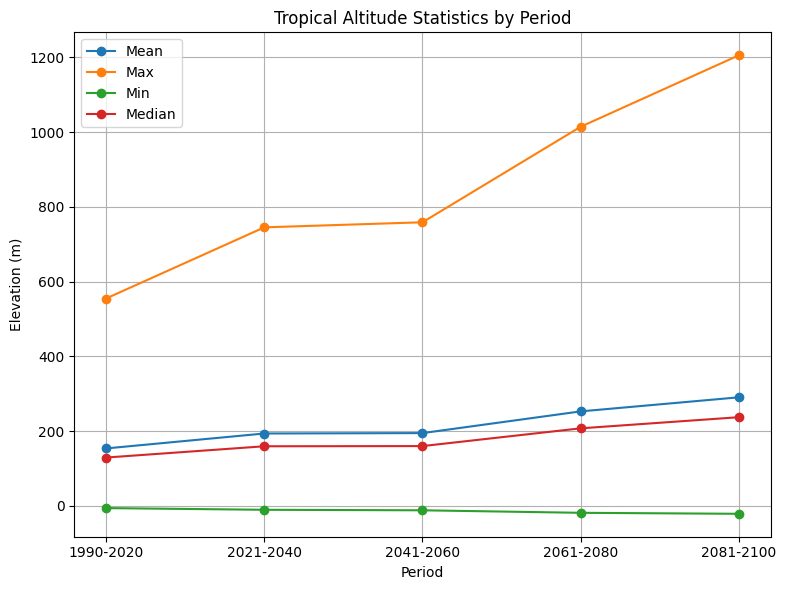

In [10]:
import matplotlib.pyplot as plt

# List the four variables to put on the same plot
vars_to_plot = ['mean_elevation', 'max_elevation', 'min_elevation', 'median_elevation']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
labels = ['Mean', 'Max', 'Min', 'Median']

fig, ax = plt.subplots(figsize=(8, 6))

for var, color, label in zip(vars_to_plot, colors, labels):
    ax.plot(df.index, df[var], marker='o', label=label, color=color)

ax.set_xlabel('Period')
ax.set_ylabel('Elevation (m)')
ax.set_title('Tropical Altitude Statistics by Period')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()
